## **Predicting Galaxy Collision**

#### **Introduction**(probably to be moved to README)

https://jupyterlab.readthedocs.io/en/stable/

Please ensure your image folder "miscImgs" is in the same directory as your Python notebook.

#### **1. Imports**
#### **2a. Single Layer Network**
#### **2b. Usefulness of Single Layer Network**
#### **3a. Convolution Network**
#### **3b. Usefulness of Convolution Network**
#### **4. How to visualize the weights**

# **1. Imports**

Here we import the necessary modules for both of our networks

In [63]:
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

# **2a. Single Layer Network**

This was our starting network.  A simple single layer network to see how well a neural network could learn and compare with our image data.  The data set we have is not very large, and if our single layer network is unable to show any learned behaviour then we would need to increase our data set size.  Thankfully there is visible learning, and it was able to do show us that a neural network would be able to learn and compare the models with enough accuracy to be considered useful.

##### **Function to grab and flatten images**

In [20]:
# We need to be able to take an image and turn it into information the
# net can use to learn from and compare to.  So let's turn our images into
# arrays that it will be ablt to interpret.

def grab_image_flatten(img_path_base, index, numImages):
    #Desired image dimension (image will be square ie # by # pixels)
    imageDim = 100
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = x.flatten()
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def grab_image_full(img_path_base, index, numImages):
    #Desired image dimension (image will be square ie # by # pixels)
    imageDim = 100
    
    if (index<10):
        img_path = img_path_base+"000"+str(index)+"_model.png"
    elif (index<100 and index >=10):
        img_path = img_path_base+"00"+str(index)+"_model.png"
    elif (index<1000 and index>=100):
        img_path = img_path_base+"0"+str(index)+"_model.png"
    elif (index<10000 and index>=1000):
        img_path = img_path_base+str(index)+"_model.png"
        
    img = image.load_img(img_path, target_size=(imageDim, imageDim), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

#Num of images to read in
numImages = 600
X = np.concatenate([grab_image_flatten('./miscImgs/',i, numImages) for i in range(numImages)]) 
X /= 255.0
Xoriginal = np.concatenate([grab_image_full('./miscImgs/',i, numImages) for i in range(numImages)]) 
Xoriginal /= 255.0

display(X.shape)
display(Xoriginal.shape)

(600, 10000)

(600, 100, 100, 1)

##### **Load in model scores**

In [22]:
# We need to attach a human score to the image data
# so that the net can learn how correct each model is

Y = np.loadtxt('./miscImgs/scores/humanScores.txt')
Y=Y[0:600]
display(Y[0:10])
display(Y.shape)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

(600,)

##### **Shuffle model images and scores**

In [110]:
# Let's shuffle the image data to create variation in the training

p = np.random.permutation(len(X))
X_original_shuffled = Xoriginal[p]
Xshuffled = X[p]
Yshuffled = Y[p]

display(X_original_shuffled.shape)
display(Xshuffled.shape)
display(Yshuffled.shape)

(600, 100, 100, 1)

(600, 100, 100, 1)

(600,)

##### **Split into training and test data (85% for training and validation)**

In [25]:
x_train = Xshuffled[0:(round(numImages*.85)),:]
y_train = Yshuffled[0:(round(numImages*.85))]
x_original_train = X_original_shuffled[0:(round(numImages*.85)),:,:]
x_test = Xshuffled[(round(numImages*.85)): , :]
y_test = Yshuffled[(round(numImages*.85)):]
x_original_test = X_original_shuffled[(round(numImages*.85)): , : , :]

display(x_train.shape)
display(y_train.shape)
display(x_original_train.shape)
display(x_test.shape)
display(y_test.shape)
display(x_original_test.shape)

(510, 10000)

(510,)

(510, 100, 100, 1)

(90, 10000)

(90,)

(90, 100, 100, 1)

##### **Build net**

In [26]:
# Let's build our single layer network

model = keras.Sequential()

input_size = x_train.shape[1]
model.add(keras.layers.Dense(1, activation='sigmoid', input_shape=[input_size]))

model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['mse'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


##### **Train it!**

In [28]:
batch_size = 4
epochs = 250
history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split = 0.3)

##### **Generate loss (MSE) plot**

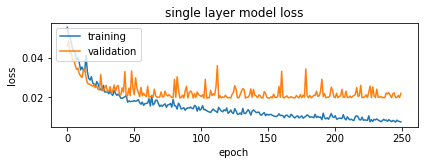

In [29]:
# We can see how well our net learned on the data
# for the given batch size and number of epochs

plt.figure()
#* summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('single layer model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("SingleModelLoss.png")
plt.show()

##### **Test on remaining 90 images and calculate mean difference between predicted and actual scores**

In [30]:
# Here we can test how well our network rates an image
# in comparison to the human scores given.

loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss final")
print(loss[-1])
print("Validation loss final")
print(val_loss[-1])

Training loss final
0.007696352401435739
Validation loss final
0.02205104377878574


In [31]:
preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.11148064812805918

##### **Save model**

In [62]:
model.save("CurSingleModel")

# **2b. What the Single Layer Model accomplishes**

The single layer network is accurate enough to say that it works, but there is still too much variation in our results to consider a single layer network as a replacement for human scoring.

##### **Various data plots**

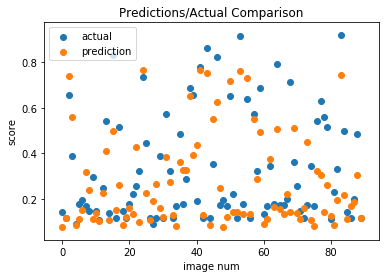

<Figure size 14400x1440 with 0 Axes>

In [32]:
shuffledInd = np.linspace(0,(numImages-round(numImages*.85))-1,num = numImages-(round(numImages*.85)))

plt.figure()
plt.scatter(shuffledInd, y_test)
plt.scatter(shuffledInd, preds)
plt.title("Predictions/Actual Comparison")
plt.ylabel("score")
plt.xlabel("image num")
plt.legend(['actual', 'prediction'], loc='upper left')
plt.figure(figsize=(200,20))
plt.show()

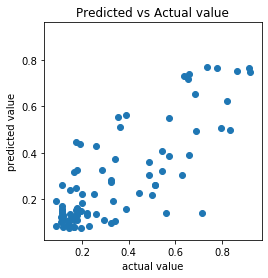

In [33]:
plt.figure()
plt.scatter(y_test, preds)
plt.title("Predicted vs Actual value")
plt.ylabel("predicted value")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("SinglePredictedVAct.png")
plt.show()

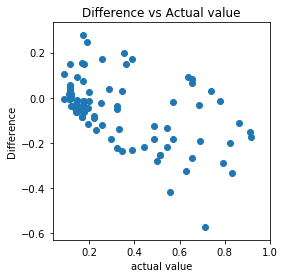

In [34]:
plt.figure()
plt.scatter(y_test, diff)
plt.title("Difference vs Actual value")
plt.ylabel("Difference")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("SingleDiffVAct.png")
plt.show()

##### **Find the 10 worst and 5 best predictions**

In [36]:
# We can view our best and worst predictions from the model
# the "top" array being our best, and "bottom" array being our worst
# our ratings are based on how close the model rated a particular image
# in regards to the actual human score attached to the image.

absDiff = np.abs(diff)

top10 = np.argpartition(absDiff, -10)[-10:]
bottom5= np.argpartition(absDiff, 5)[:5]
display(top10)
display(bottom5)

array([79, 17, 39, 73, 84, 78, 77, 68, 64, 15])

array([ 4, 89, 26,  1, 19])

##### **Show the 10 worst and 5 best predictions**

In [ ]:
# Let's start with our best predictions that the net was able to give

for i in range (int(top10)):
    plt.imshow(image.array_to_img(x_original_test[top10[0],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[top10[0]])
    print("Prediction")
    display(preds[top10[0]][0])

In [ ]:
# And for comparison we will also view the worst predictions the model gave

for i in range (int(bottom5)):
    plt.imshow(image.array_to_img(x_original_test[bottom5[0],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[bottom5[0]])
    print("Prediction")
    display(preds[bottom5[0]][0])

##### **Show the model that the net gave the highest and lowest scores**

In [ ]:
# We can also view our highest scoring model

maxPred = np.amax(preds, axis=0)
maxPredIndex = np.where(preds == maxPred)

plt.imshow(image.array_to_img(x_test[maxPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[maxPredIndex[0][0]])
print("Prediction")
display(preds[maxPredIndex[0][0]][0])

In [ ]:
# As well as our lowest scoring model

minPred = np.amin(preds, axis=0)
minPredIndex = np.where(preds == minPred)

plt.imshow(image.array_to_img(x_test[minPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[minPredIndex[0][0]])
print("Prediction")
display(preds[minPredIndex[0][0]][0])

# **3a. Convolution Network**

With our single layer network we are able to show that the network was able to learn and score models.  However, the accuracy we achieved is not quite what we are looking for.  For this reason we decided to move to a Convolution Network.

##### **Grab images again**

In [65]:
numImages = 600
X=np.concatenate([grab_image_full('./miscImgs/',i, numImages) for i in range(numImages)]) 
X /= 255.0

X.shape

(600, 100, 100, 1)

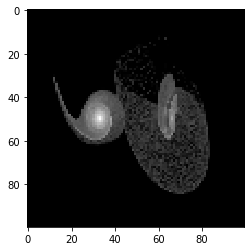

In [66]:
# Let's validate that our image data was loaded correctly

plt.imshow(image.array_to_img(X[45,:,:,:]), cmap='Greys_r')
plt.show()

##### **Load in model scores**

In [70]:
# Again let's attach a human score to the images.

Y = np.loadtxt('./miscImgs/scores/humanScores.txt')
Y=Y[0:600]
display(Y[0:10])
display(Y.shape)

array([0.945946, 0.941176, 0.918919, 0.916667, 0.916667, 0.914286,
       0.914286, 0.911765, 0.891892, 0.885714])

(600,)

##### **Shuffle model images and scores**

In [71]:
# Randomize the image data again

p = np.random.permutation(len(X))
Xshuffled = X[p]
Yshuffled = Y[p]

display(Xshuffled.shape)
display(Yshuffled.shape)

(600, 100, 100, 1)

(600,)

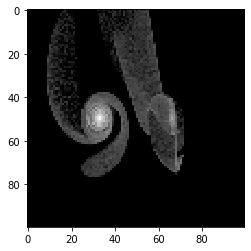

0.305556

In [72]:
# Verify that the images were shuffled, while keeping their human score intact 

plt.imshow(image.array_to_img(Xshuffled[0,:,:,:]), cmap='Greys_r')
plt.show()
display(Yshuffled[0])

##### **Split into training and test data (85% for training and validation)**

In [73]:
x_train = Xshuffled[0:(round(numImages*.85)),:,:]
y_train = Yshuffled[0:(round(numImages*.85))]
x_test = Xshuffled[(round(numImages*.85)): , : , :]
y_test = Yshuffled[(round(numImages*.85)):]

display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

(510, 100, 100, 1)

(510,)

(90, 100, 100, 1)

(90,)

##### **Build net and show the architecture**

In [74]:
# Description of the model(need some help)

model = keras.Sequential()
model.add(keras.layers.Conv2D(16, kernel_size=(12, 12),
                activation='relu',
                input_shape=[x_test.shape[1],
                x_test.shape[2],
                x_test.shape[3]]))
model.add(keras.layers.Conv2D(32, kernel_size=(8, 8), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['mse'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 89, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 82, 82, 32)        32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 41, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 53792)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1721376   
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

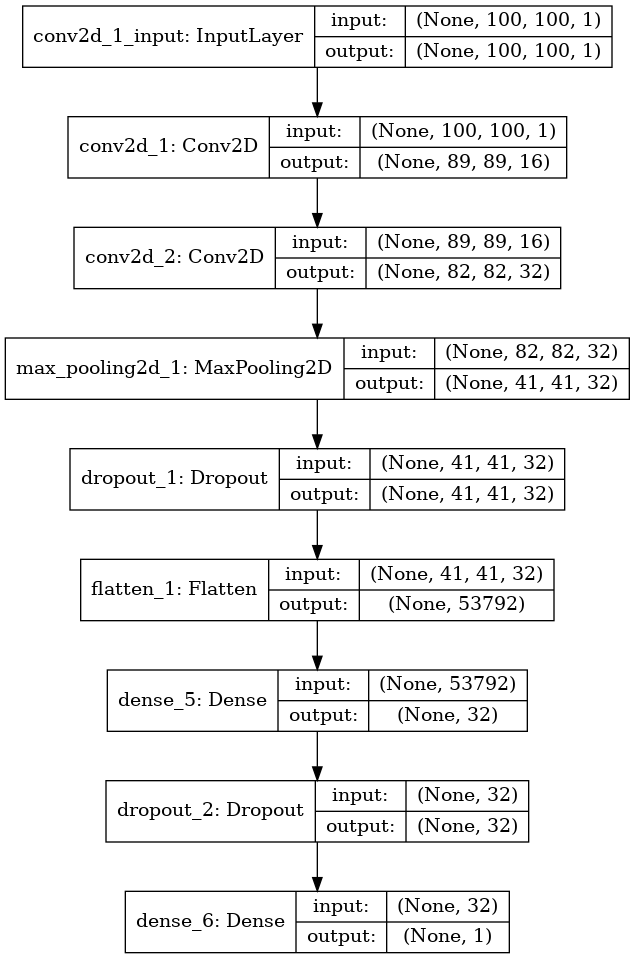

In [75]:
plot_model(model,to_file='convNet.png',show_shapes=True,expand_nested=True)

##### **Train it**

In [111]:
# Let's train our model on our randomized set of image data
# (something something overfitting?)

batch_size = 4
epochs = 120
history = model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    validation_split = 0.3)

##### **Generate loss (MSE) plot**

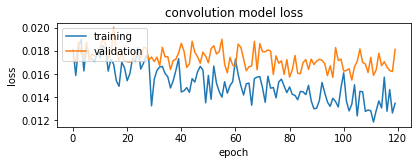

In [112]:
# We can view how well our model trained with our chosen 
# batch size and number of epochs.

plt.figure()
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('convolution model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.tight_layout()
plt.savefig("ConvModelLoss.png")
plt.show()

##### **Test on remaining 90 images and calculate mean difference between predicted and actual scores**

In [113]:
# This is validation of how well our model performs
# during actual comparisons.

preds = model.predict(x_test)
diff = preds.flatten() - (y_test)
print("Mean difference")
print("---------------")
display(np.mean(np.abs(diff)))

Mean difference
---------------


0.10570466957589784

##### **Save model**

In [114]:
model.save("CurConvModel")

# **3b. What the Convolution Network accomplishes**

With a convolution network we were able to achieve much better results with our comparisons.  With a larger data set we believe the network would be able to mirror the human scores, or even potentially score a model better than humans could.

##### **Various data plots**

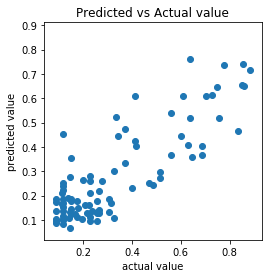

In [115]:
plt.figure()
plt.scatter(y_test, preds)
plt.title("Predicted vs Actual value")
plt.ylabel("predicted value")
plt.xlabel("actual value")
plt.savefig("ConvPredictedVAct.png")
plt.axis('square')
plt.show()

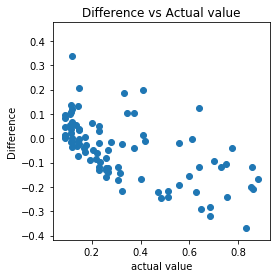

In [116]:
plt.figure()
plt.scatter(y_test, diff)
plt.title("Difference vs Actual value")
plt.ylabel("Difference")
plt.xlabel("actual value")
plt.axis('square')
plt.savefig("ConvDiffVAct.png")
plt.show()

##### **Find the 10 worst and 5 best predictions**

In [119]:
# We can again view our best and worst predictions from the model
# the "top" array being our best, and "bottom" array being our worst
# our ratings are based on how close the model rated a particular image
# in regards to the actual human score attached to the image.

## WANT TO CHANGE THIS AROUND TO MAKE MORE SENSE ##

absDiff = np.abs(diff)

top10 = np.argpartition(absDiff, -10)[-10:]
bottom5 = np.argpartition(absDiff, 5)[:5]
display(top10)
display(bottom5)

## WANT TO CHANGE THIS TO MAKE MORE SENSE ##

array([40, 69, 63,  1, 37, 17, 67, 51, 14, 64])

array([43, 52, 53, 60, 27])

##### **Show the 10 models that had the largest difference between predicted and human score**

In [120]:
for i in range (int(top10)):# change to bottom
    plt.imshow(image.array_to_img(x_test[top10[0],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[top10[0]])
    print("Prediction")
    display(preds[top10[0]][0])

TypeError: only size-1 arrays can be converted to Python scalars

##### **Show the 5 models that the net had the closest prediction on**

In [103]:
for i in range (bottom5):#change to top
    plt.imshow(image.array_to_img(x_test[bottom5[0],:,:,:]), cmap='Greys_r') 
    plt.show()

    print("Human Score")
    display(y_test[bottom5[0]])
    print("Prediction")
    display(preds[bottom5[0]][0])

TypeError: only integer scalar arrays can be converted to a scalar index

##### **Show the models that the net gave the highest and lowest scores**

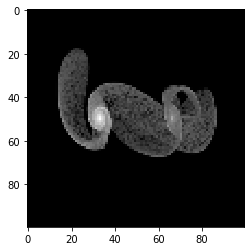

Human Score


0.638889

Prediction


0.7624424

In [121]:
# Let's view our highest scoring model

maxPred = np.amax(preds, axis=0)
maxPredIndex = np.where(preds == maxPred)

plt.imshow(image.array_to_img(x_test[maxPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[maxPredIndex[0][0]])
print("Prediction")
display(preds[maxPredIndex[0][0]][0])

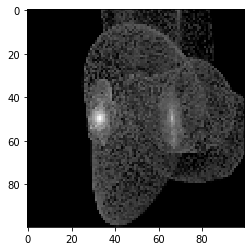

Human Score


0.142857

Prediction


0.0683184

In [122]:
# As well as our lowest scoring model

minPred = np.amin(preds, axis=0)
minPredIndex = np.where(preds == minPred)

plt.imshow(image.array_to_img(x_test[minPredIndex[0][0],:,:,:]), cmap='Greys_r') 
plt.savefig("ConvPredictedBest.png")
plt.show()

print("Human Score")
display(y_test[minPredIndex[0][0]])
print("Prediction")
display(preds[minPredIndex[0][0]][0])

# **4. How to visualize the weights**

It is sometimes helpful to see what the neural network itself views as important.  In order to do this we can model the weights in the way that the net sees them.

##### **Function to dislay weights for single layer network**

In [108]:
def view_weights( model, saveLoc = None ):
    weights = model.get_weights()[0]
    l = weights[:,0]
    #(100,100) dependent on image size
    l = np.reshape( l, (100,100) )

    plt.imshow(l)
    
    if saveLoc != None:
        plt.savefig( saveLoc )
        
    plt.show()

In [109]:
view_weights(model, saveLoc = "singleWeights.png")

ValueError: cannot reshape array of size 192 into shape (100,100)

In [85]:
weights = model.get_weights()
len(weights)

8

In [86]:
# What's the shape of the tensor
# for the connection weights at
# the -first- Conv2D layer?
weights[0].shape

(12, 12, 1, 16)

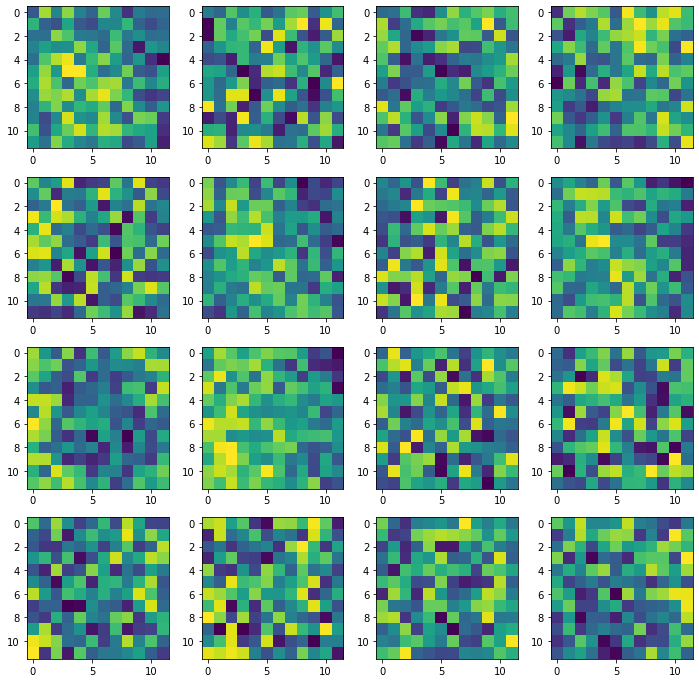

In [87]:
fig,axes = plt.subplots(4,4)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(4):
    for y in range(4):
        data = weights[0][:,:,:,(x*4)+y].reshape(12,12)
        
        axes[x,y].imshow(data)
plt.savefig("convWeight1.png")
plt.show()

In [88]:
weights[2].shape

(8, 8, 16, 32)

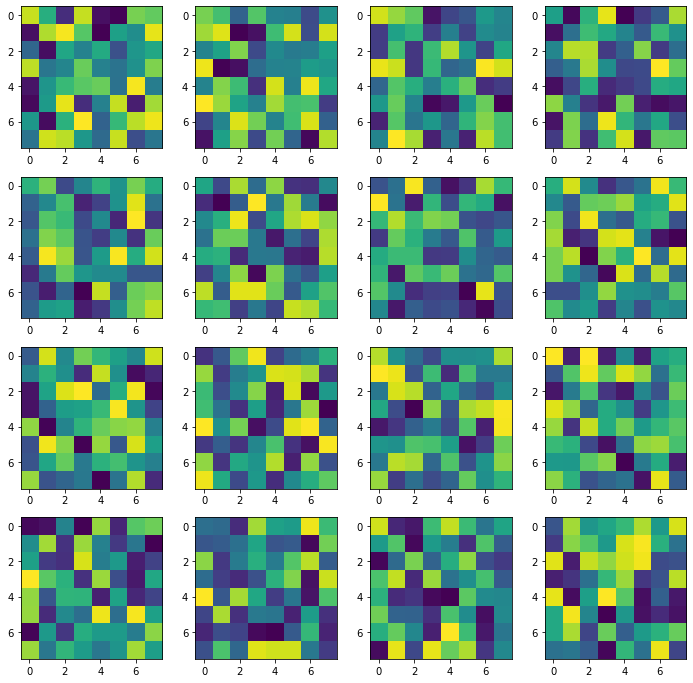

In [89]:
fig,axes = plt.subplots(4,4)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(4):
    for y in range(4):
        data = weights[2][:,:,(x*4)+y,0].reshape(8,8)
        
        axes[x,y].imshow(data)
plt.savefig("convWeight2.png")
plt.show()

In [91]:
inp = model.input
outputs = [layer.output for layer in model.layers]
functor = K.function([inp,K.learning_phase()], outputs)

In [92]:
layer_outputs = functor([x_test[10:11,:,:,:],1])
len(layer_outputs)

8

In [93]:
layer_outputs[0].shape

(1, 89, 89, 16)

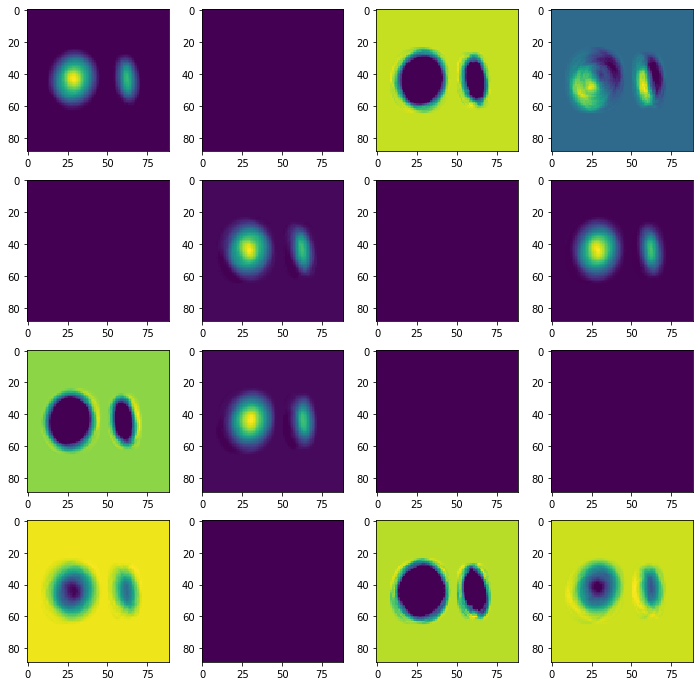

In [94]:
fig,axes = plt.subplots(4,4)
fig.set_figwidth(12)
fig.set_figheight(12)
for x in range(4):
    for y in range(4):
        axes[x,y].imshow(layer_outputs[0][0,:,:,(x*4)+y])
plt.savefig("layer1activations")
plt.show()